# **Recurrent Neural Network**

**Importing Libraries**

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset #train ve test dataları pytorch'ta kullanılabilir hale getirilmek için DataLoader methodu kullanılır.

**Data Preprocessing**

In [2]:
train = pd.read_csv(r"C:\Users\ŞEVVAL\Desktop\train.csv",dtype = np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
targets_numpy = train.label.values
features_numpy = (train.loc[:,train.columns != "label"].values)/255 #normalization

values methodu ile label pandas series'ten numpy array'e çevrilir. 

Algoritmanın daha hızlı çalışması için rgb formatındaki pikseller 255'e bölünerek 0-1 aralığına çekilir.

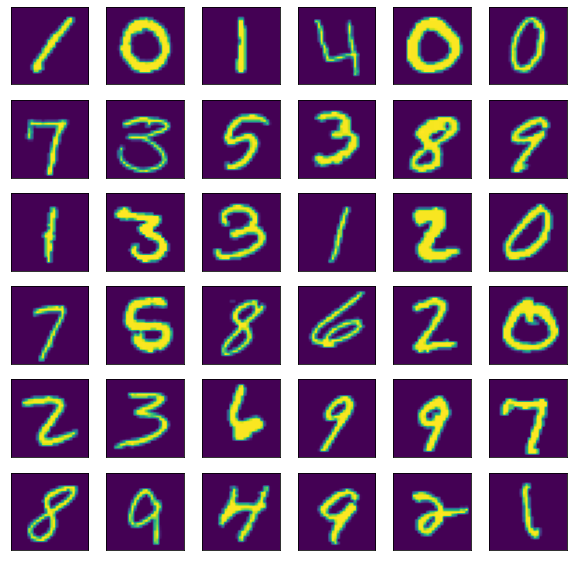

In [4]:
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = [features_numpy[i]]
    img = np.reshape(img, (28, 28))
    plt.imshow(img)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

In [6]:
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

In [7]:
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

Numpy array'ler pytorch kütüphanesinde kullanılabilmek için tensor'e dönüştürülür.

In [8]:
#hyperparameter
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size) #(10000/(33600/100)) = 29 -> epoch
num_epochs = int(num_epochs)  #29 epoch

**batch size verinin kaça bölünerek train edileceğidir.**

Eğer data 1000 sample'dan oluşuyorsa batch size 100 olarak belirlendiğinde, data 100'er sample'dan oluşan 10 gruba ayrılır.

**Epoch train datası kullanılarak kaç defa training işleminin gerçekleştirileceğidir.**

Datada 33600 sample bulunmaktadır. batch size 100, epoch 29 olarak belirlenmiştir.

Bu durumda (33600)/(100) = 336 grup oluşacaktır.

Bir epoch 336 training işlemi gerçekleşeceğinden, bir epoch 336 iteration'dan oluşur.

Bu durumda 29 epoch'ta 9744 iteration bulunur, yaklaşık 9500 denilebilir.

In [9]:
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

Oluşturulan train ve test datası tensor formatındaydı, TensorDataset methoduyla datasete çevrilip network'e yüklenmiştir.

In [10]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

DataLoader methoduyla dataset ve samplelar batch size'a göre combine edilir.

**Create RNN Model**

In [11]:
# Create RNN Model
class RNNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):     
        #input dimension -> 28x28 =784
        #hidden dimension -> 100 olarak belirlendi.
        #output dimension -> 0-9 arası rakamlar oluştuğu için 10 olarak belirlendi.
        
        super(RNNModel, self).__init__() #RNN modeli nn.Module'ün initializer'ı çağırılarak inherit edilir.
        
        #Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        #Number of hidden layers
        self.layer_dim = layer_dim
        
        #hidden dimension ve layer dimension forward methodunda kullanılacağı için constructor içerisinde tanımlanır.
        
        #RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        #rnn modelinde batch_first=True output shape (batch_size, seq_len, hidden_size) sıralamasıyla,
        #batch_first=False olduğunda  (seq_len, batch_size, hidden_size) sıralamasıyla bir liste olur.
        #seq_len -> layerların uzunluğu
        #non_linearity'i artıracak activation function olarak relu kullanılmıştır.
        
        #fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        #hidden layer 0'lardan oluşan bir Variable olarak oluşturulur.
            
        #One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        #(batch_size, seq_len, hidden_size) sıralamasında en sonuncu sequence (fully connected layer) alınır.
        
        return out

**Instantiate Model Class**

In [12]:
#Hyperparameter
input_dim = 28    #input dimension
hidden_dim = 100  #hidden layer dimension
layer_dim = 1     #number of hidden layers
output_dim = 10   #output dimension

In [13]:
#Create RNN
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

**Instantiate Loss Class**

In [14]:
#Cross Entropy Loss 
error = nn.CrossEntropyLoss()

y_head değerinin gireceği softmax activation function CrossEntropyLoss methodunun içerisinde bulunur.

CrossEntropyLoss methoduyla loss değeri hesaplanır.

**Instantiate Optimizer Class**

In [15]:
#SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Stochastic Gradient Descent yöntemi ile parametreler güncellenecektir.

**Training Model and Prediction**

In [16]:
#RNN Model Training

seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim))
        #view methoduyla görseller flatten yapılarak bir vektör haline getirilir.
        labels = Variable(labels)
        #backward propagation'da hesaplanan gradient'ler pytorch'ta accumulate edilebilmesi Variable yapısında olmalıdır.
            
        #türevler 0'lanır, eğer sıfırlanmazsa her adımda bir önceki adımdaki türevlerle toplanır.
        #türev değerleri sıfırlanmadan önce backward methoduyla Variable içerisinde accumulate edildiği için kaybolmamıştır.
        optimizer.zero_grad()
        
        #Forward propagation yapılması için model çağrılır.
        outputs = model(train)
        
        #softmax ve cross entropy loss hesaplanır.
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        #loss'un parametrelere göre türevi alınarak, parametrelerin ne kadar güncelleneceği bulunur.
        
        # Update parameters
        optimizer.step()
        #parametreler update edilir. (w = w- learning_rate*gradient)
        
        count += 1
        
        if count % 250 == 0: #count 250 ve 250'nin katları olduğu sürece prediction işlemi gerçekleştirilir.
            
            # Calculate Accuracy         
            correct = 0 #doğru tahmin edilenler
            total = 0 #tahmin edilenlerin tümü
            
            # Iterate through test dataset
            for images, labels in test_loader:
                
                images = Variable(images.view(-1, seq_dim, input_dim))
                #test isimli bir variable'a image'ler eşitlenir.
                
                # Forward propagation
                outputs = model(images)
                #0-9 arası classlardan prediction işlemi gerçekleştirilir.
                #probabilistic bir sonuç ortaya çıkar.
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                #probabilistic değerlerden en olası olana (1'e en yakın olana) bakılır ve indeksi alınır.
                
                # Total number of labels
                total += labels.size(0)
                #test datasında kaç sample olduğuna bakılır.
                
                correct += (predicted == labels).sum()
                #predicted ile total aynı ise doğru tahmindir, correct isimli variable'a eklenir.
            
            accuracy = 100 * (correct / float(total))
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            if count % 500 == 0: #count 500'ün katı oldukça accuracy ve loss değerleri yazdırılır.
                
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 2.2944536209106445  Accuracy: 19.333332061767578 %
Iteration: 1000  Loss: 1.1149990558624268  Accuracy: 47.78571319580078 %
Iteration: 1500  Loss: 0.5920172929763794  Accuracy: 82.20237731933594 %
Iteration: 2000  Loss: 0.4853559732437134  Accuracy: 82.83332824707031 %
Iteration: 2500  Loss: 0.21486754715442657  Accuracy: 89.76190948486328 %
Iteration: 3000  Loss: 0.20642493665218353  Accuracy: 92.13095092773438 %
Iteration: 3500  Loss: 0.526227593421936  Accuracy: 74.13095092773438 %
Iteration: 4000  Loss: 0.15739023685455322  Accuracy: 93.55952453613281 %
Iteration: 4500  Loss: 0.333797425031662  Accuracy: 93.75 %
Iteration: 5000  Loss: 0.18931180238723755  Accuracy: 94.71428680419922 %
Iteration: 5500  Loss: 0.29312238097190857  Accuracy: 94.7261962890625 %
Iteration: 6000  Loss: 0.21159517765045166  Accuracy: 94.96428680419922 %
Iteration: 6500  Loss: 0.06333871930837631  Accuracy: 95.20237731933594 %
Iteration: 7000  Loss: 0.26901134848594666  Accuracy: 92.66

**Visualization**

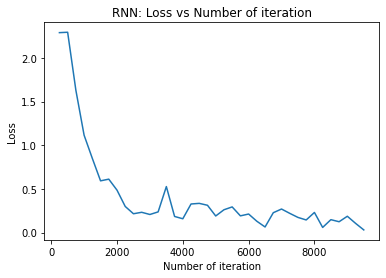

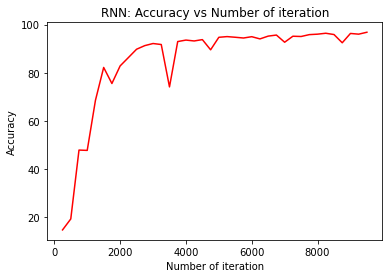

In [17]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()